<a href="https://colab.research.google.com/github/mmatera/Spin-Chains-/blob/main/HS_projected_evolution_debugged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip
!pip install scipy
!pip install matplotlib.inline
!pip install numpy
!pip install networkx

In [1]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import math, cmath
import proj_ev_tools as me

from IPython.display import display, Math, Latex

In [2]:
N = 2           # número de spines

h  = 1.0 * 2 * np.pi * np.ones(N) 
Jx = 0.15 * 2 * np.pi * np.ones(N)
Jy = 0.25 * 2 * np.pi * np.ones(N)
Jz = 0.1 * 2 * np.pi * np.ones(N)

In [3]:
### Operadores de spin y hamiltoniano

## 1-operadores
spin_list = me.one_body_spin_ops(N)
globalid_list, sx_list, sy_list, sz_list = spin_list
pauli_vec = [sx_list, sy_list, sz_list]

## 2-operadores
two_body_spin_list = me.all_two_body_spin_ops(N, pauli_vec)

## Hamiltoniano 
H_H = me.Heisenberg_hamiltonian(N, Jx, Jy, Jz, h)
#qutip.hinton(rho=H_H, title = "Heisenberg's hamiltonian Hinton diagram")

### Free particle-Operators en términos de los operadores de spin
x_op, p_op, comm_xp, corr_xp, p_dot = me.free_particle_ops(N, H_H, sz_list)

In [4]:
## si quiero un estado max-ent-1 uso esta matriz de coeficientes e invoco la función 
coeffs_me1 = [[10**-10,2*10**-10],[np.pi*10**-10,10**-18],[10**-18,10**-18],[10**-18,10**-18]]
me.n_body_max_ent_state(1, N, coeffs_me1)

## si quiero un estado max-ent-2, uso alguna de estas dos matrices 
## de coeficientes e invoco la función
a = len(me.all_two_body_spin_ops(N, pauli_vec))
b = len(me.all_two_body_spin_ops(N, pauli_vec)[0])

me.all_two_body_spin_ops(N, pauli_vec)

coeffs_sz = [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [10**-5, 10**-5, 10**-5, 10**-5, 10**-5, 10**-5,
              10**-5, 10**-5, 10**-5, 10**-5, 10**-5, 10**-5]]

coeffs_all = 10**-0.6 * np.full((a,b),1.)

In [5]:
# Estas definiciones quedaron obsoletas pero sirven para el testeo de la n_body_basis
one_site_basis = globalid_list + sx_list + sy_list + sz_list 
two_site_basis = [op1*op2 for op1 in one_site_basis for op2 in one_site_basis]

tercera_base = [op*op3 for op in two_site_basis for op3 in one_site_basis]
three_site_basis = [op1*op2*op3 for op1 in one_site_basis for op2 in one_site_basis for op3 in one_site_basis]

cuarta_base = [op*op4 for op in three_site_basis for op4 in one_site_basis]
four_site_basis = [op1*op2*op3*op4 for op1 in one_site_basis for op2 in one_site_basis for op3 in one_site_basis for op4 in one_site_basis]

In [6]:
# def isnatural(x):
#   return isinstance(x, int) and 0 <= x <= 9

## globalid_list tiene N operadores anidados
## sx_list, sy_list, sz_list ídem, N operadores c/u. 
## La 1-base completa tiene 4N operadores de 1-cuerpo
## La 2-base completa tiene 4N*{4N} operadores de 2-cuerpos
## La 3-base completa tiene {4N*{4N}}*4N} operadores 

natural = tuple('123456789')

def n_body_basis(n):
    basis = []
    if (isinstance(n,int) and str(n) in natural):
        if (n == 1):
            basis = globalid_list + sx_list + sy_list + sz_list
        elif (n > 1):
            basis = [op1*op2 for op1 in n_body_basis(n-1) for op2 in n_body_basis(1)]
    else:
        basis = 'beep boop, n must be natural'
    return basis

In [7]:
uno_a_cuatro_bases = []
uno_a_cuatro_bases.append(one_site_basis)
uno_a_cuatro_bases.append(two_site_basis)
uno_a_cuatro_bases.append(three_site_basis)
uno_a_cuatro_bases.append(four_site_basis)

def basis_defs_test():
    boolean = False 
    for n in range(4): 
        for m in range(3):
            if (n_body_basis(n+1) == uno_a_cuatro_bases[m] and n != m):
                print('Error: Two different index basis definitions equal', boolean)
            if (n_body_basis(n+1) != uno_a_cuatro_bases[m] and n == m):
                print('Error: Two same index basis definitions not equal', boolean)
            else:
                print('OK', True)
    return None

basis_defs_test()

OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True


In [8]:
%%latex

Si quiero un estado gaussiano de operadores de un cuerpo, el más general es 

$$
\rho_{1,g} = \exp\bigg(\alpha I_N + {\bf a}_1 \cdot {\bf s}_x+{\bf a}_2 \cdot {\bf s}_y+{\bf a}_3 \cdot {\bf s}_z\bigg) 
$$

análogamente con estados gaussianos de operadores de dos cuerpos (pero ya ahí se me va al carajo).
Si en cambio, considero un estado no gaussiano, puedo considerar un estado inicial descorrelacionado de la forma de 

$$
\rho_0 = x |\Phi\rangle \langle\Phi| + (1-x)\frac{{I_d}}{d}
$$

<IPython.core.display.Latex object>

In [9]:
## ket combinación lineal 

psi1_list = []; psi2_list = []
psi1_list.append(qutip.basis(2,1))
for n in range(N-1):
    psi1_list.append(qutip.basis(2,0))

psi2_list.append(qutip.basis(2,0))
psi2_list.append(qutip.basis(2,1))
for n in range(N-2):
    psi2_list.append(qutip.basis(2,0))

psi01 = qutip.tensor(psi1_list); psi02 = qutip.tensor(psi2_list) 
psi0 = psi01#+psi02 #sí está en el ME2, aparece un proyector s1, s2 -> estado ME2
# rho = psi0 * psi0.dag() entrelazado
## estado no gaussiano

loc_globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])
me.initial_state(N, True, 2, .5, coeffs_sz, psi0)
#qutip.hinton(.5 * psi0 * psi0.dag() + (1-.5) * loc_globalid * .5**N) # no es ME1, es un no gaussiano.

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.000010e+00+0.000000e+00j  5.000025e-06-5.000025e-06j
   5.000025e-06-5.000025e-06j  0.000000e+00+0.000000e+00j]
 [ 0.000000e+00+0.000000e+00j  1.000000e+00+0.000000e+00j
   0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j]
 [ 0.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j
   1.000000e+00+0.000000e+00j  0.000000e+00+0.000000e+00j]
 [ 0.000000e+00+0.000000e+00j -5.000025e-06-5.000025e-06j
  -5.000025e-06-5.000025e-06j  1.000010e+00+0.000000e+00j]]

In [10]:
### Algunas analytics de los estados usados

## Estado Max Ent 1

coeffs_me1 = [[10**-10,2*10**-10],[np.pi*10**-10,10**-18],[10**-18,10**-18],[10**-18,10**-18]]
rho_me1 = me.initial_state(N, True, 1, None, coeffs_me1, None)
rho_me1 = rho_me1/rho_me1.tr()
print("Tr(rho_me1^2) =",(rho_me1**2).tr()) ## nuevamente, no es un estado puro porque tr rho² != 1
                                           ## estado mixto rho_me1 = sum c_i ket(psi_i) bra(psi_i)
print("S(rho_me1^2) =", qutip.entropy_vn(rho_me1)) ## nuevamente un estado mixto porque da mayor a 1

## y cómo se sí es entrelazado o no?

## Estado Max-En2
coeffs_sz = [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
             [10**-10, 10**-5, 10**-10, 10**-5, 10**-10, 10**-5, 
              10**-10, 10**-5, 10**-10, 10**-5, 10**-10, 10**-5]]
rho_me2 = me.initial_state(N, True, 2, None, coeffs_sz, None)
rho_me2 = rho_me2/rho_me2.tr()
print("Tr(rho_me2^2) =",(rho_me2**2).tr()) ## nuevamente, no es un estado puro porque tr rho² != 1
                                           ## estado mixto rho_me2 = sum c_i ket(psi_i) bra(psi_i)
print("S(rho_me2^2) =", qutip.entropy_vn(rho_me2)) ## nuevamente un estado mixto no da 0 

## Estado no gaussiano
rho_ng = me.initial_state(N, False, None, .5, None, psi0)
print("Tr(rho_ng^2) =",(rho_ng**2).tr()) ## nuevamente, no es un estado puro porque tr rho² != 1
                                         ## sum c_i ket(psi_i) bra(psi_i)
print("S(rho_ng^2) =", qutip.entropy_vn(rho_ng)) ## nuevamente un estado mixto porque no da 0

Tr(rho_me1^2) = 0.25
S(rho_me1^2) = 1.3862943611198906
Tr(rho_me2^2) = 0.2500000000015626
S(rho_me2^2) = 1.3862943611167657
Tr(rho_ng^2) = 0.4375
S(rho_ng^2) = 1.073542846408523


In [11]:
## Algunas métricas de los estados
print(me.bures(me.initial_state(N, True, 1, .5, coeffs_me1, None), me.initial_state(N, False, 1, .5, None, psi0)))
print(me.rel_entropy(me.initial_state(N, True, 1, .5, coeffs_me1, None), me.initial_state(N, False, 1, .5, None, psi0)))
print(me.rel_entropy(me.initial_state(N, False, 1, .5, None, psi0),me.initial_state(N, True, 1, .5, coeffs_me1, None)))

0.0
6.708328257497742
-1.0735428467085233


In [12]:
class one_body_max_ent(qutip.Qobj):
    def __init__(self, rho_me1):
        super().__init__(qutip.Qobj)
        self.rho_me1 = me.n_body_max_ent_state(1, N, coeffs_me1)

class two_body_max_ent(qutip.Qobj):
    def __init__(self, rho_me2):
        super().__init__(qutip.Qobj)
        self.rho_me2 = me.n_body_max_ent_state(2, N, coeffs_sz) 

rho1 = one_body_max_ent(coeffs_me1)
rho2 = two_body_max_ent(coeffs_sz)

print(rho1.__dict__)

/home/tomas/.conda/envs/qutip/lib/python3.10/site-packages/qutip/qobj.py:303: UserWarning: Initializing Qobj from unsupported type: <class 'type'>
  warnings.warn("Initializing Qobj from unsupported type: %s" %


{'_isherm': None, '_type': None, 'superrep': None, '_isunitary': None, '_data': <1x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements in Compressed Sparse Row format>, 'dims': [[1], [1]], 'rho_me1': Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1.00000000e+00 0.00000000e+00 1.57079633e-10 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 1.57079633e-10]
 [1.57079633e-10 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.57079633e-10 0.00000000e+00 1.00000000e+00]]}


In [ ]:
HS_modified = True

class Result(object):
      def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

def callback(t, rhot):
    global rho
    rho = rhot

# Algunos problemas que tiene el problema cómo está planteado ahora:
    # * rho0 debería ser un estado descorrelacionado. Aquí estamos estando el estado inicial,
    #   que es un estado entrelazado
    # * El estado inicial no pertenece a la variedad Max-Ent: Para que esto funcione, deberíamos, o bien proyectar el estado inicial a la variedad,
    # o bien agregar el log(rho0) a la base de operadores. 
    
def projected_evolution(author=True,x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, 
                        gaussian=False, gr = int, deltat=10., tmax = 500., distance=me.bures, 
                        do_project=True):
    global rho
    loc_globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])

    if (gaussian and gr == 1):
        coeffs_me1_gr1 = [[10**-1,2*10**-1],[np.pi*10**-1,10**-18],
                          [10**-18,10**-18],[10**-18,10**-18]]
        rho0 = me.initial_state(N, gaussian, gr, None, coeffs_me1_gr1, None)
        
    elif(gaussian and gr == 2):
        coeffs_me2_sz = [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                         [10**-10, 10**-5, 10**-10, 10**-5, 10**-10, 10**-5,
                          10**-10, 10**-5, 10**-10, 10**-5, 10**-10, 10**-5]]
        rho0 = me.initial_state(N, gaussian, gr, None, coeffs_me2_sz, None)
        
    elif(not gaussian):
        coeffs_nop = []
        rho0 = me.initial_state(N, gaussian, gr, x, coeffs_nop, psi0)
          
    
    if (author):
        basis = me.base_orth(n_body_basis(2), rho0)  ## // Á la Tom
    else: 
        basis = me.base_orth(two_site_basis, rho0) ## // Á la Mauricio
        
    obs = [x_op, p_op, comm_xp, corr_xp]
          #, x_op**2,p_op**2, corr_op, p_dot]
        
    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    c_op_list = me.spin_dephasing(N,gamma)
    rho_init = rho0                                                               ## // Á la Mauricio
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=H_H, 
                               rho0=rho

In [19]:
HS_modified = True

class Result(object):
      def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

def callback(t, rhot):
    global rho
    rho = rhot

# Algunos problemas que tiene el problema cómo está planteado ahora:
    # * rho0 debería ser un estado descorrelacionado. Aquí estamos estando el estado inicial,
    #   que es un estado entrelazado
    # * El estado inicial no pertenece a la variedad Max-Ent: Para que esto funcione, deberíamos, o bien proyectar el estado inicial a la variedad,
    # o bien agregar el log(rho0) a la base de operadores. 
    
def projected_evolution(author=True,x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, 
                        gaussian=False, gr = int, deltat=10., tmax = 500., distance=me.bures, 
                        do_project=True):
    global rho
    loc_globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])

    if (gaussian and gr == 1):
        coeffs_me1_gr1 = [[10**-1,2*10**-1],[np.pi*10**-1,10**-18],
                          [10**-18,10**-18],[10**-18,10**-18]]
        rho0 = me.initial_state(N, gaussian, gr, None, coeffs_me1_gr1, None)
        
    elif(gaussian and gr == 2):
        coeffs_me2_sz = [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                         [10**-10, 10**-5, 10**-10, 10**-5, 10**-10, 10**-5,
                          10**-10, 10**-5, 10**-10, 10**-5, 10**-10, 10**-5]]
        rho0 = me.initial_state(N, gaussian, gr, None, coeffs_me2_sz, None)
        
    elif(not gaussian):
        coeffs_nop = []
        rho0 = me.initial_state(N, gaussian, gr, x, coeffs_nop, psi0)
          
    
    if (author):
        basis = me.base_orth(n_body_basis(2), rho0)  ## // Á la Tom
    else: 
        basis = me.base_orth(two_site_basis, rho0) ## // Á la Mauricio
        
    obs = [x_op, p_op, comm_xp, corr_xp]
          #, x_op**2,p_op**2, corr_op, p_dot]
        
    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    c_op_list = me.spin_dephasing(N,gamma)
    rho = rho0                                                               ## // Á la Mauricio
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=H_H, 
                               rho0=rho, 
                               tlist=np.linspace(0,deltat, sampling), 
                               c_ops=c_op_list, 
                               e_ops=callback,
                               args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2}
                               )
        ts.append(deltat*i)
        if do_project:
            rho = me.proj_op(me.logM(rho), basis, rho0)
            #rho = me.proj_op(me.logM(rho), basis, loc_globalid)
            e0 = max(rho.eigenenergies())
            rho = rho - loc_globalid * e0
            rho = rho.expm()
            trrho = (2.*rho.tr())
            rho = (rho+rho.dag())/trrho

        #print(qutip.entropy.entropy_vn(rho))
        newobs = [qutip.expect(rho, op) for op in obs]
        approx_exp_vals.append(newobs)

    result = {}
    result["ts"] = ts
    result["averages"] = np.array(approx_exp_vals)
    
    title = f" BW Dinámica cerrada no gaussiana wb1={omega_1} wb2={omega_2}" 
    if do_project:
        title = title + "_projected_"

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return result

sampling: 30
sampling: 30


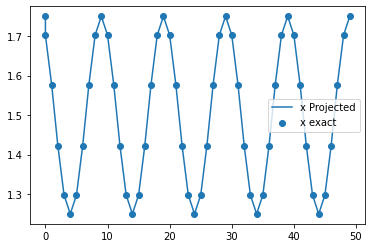

In [14]:
## usando n_body_basis(2) y el estado no gaussiano de Mauricio

results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()

sampling: 75
sampling: 75


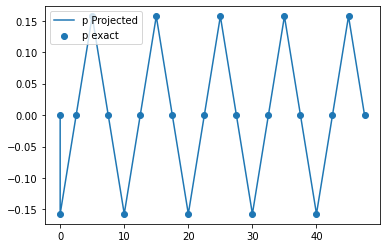

In [90]:
## el p del caso anterior

results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=2.5, tmax = 50, 
                              distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,1], label="p Projected")
results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=2.5, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="p exact")
plt.legend()

sampling: 30
sampling: 30
sampling: 30
sampling: 30


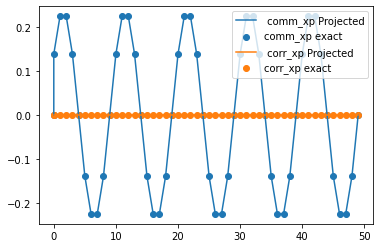

In [77]:
## usando n_body_basis(2) y el estado no gaussiano de Mauricio

results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,2], label=" comm_xp Projected")
results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,2], label="comm_xp exact")

## ---- ## 

results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,3], label=" corr_xp Projected")
results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,3], label="corr_xp exact")

plt.legend()

sampling: 30
sampling: 30


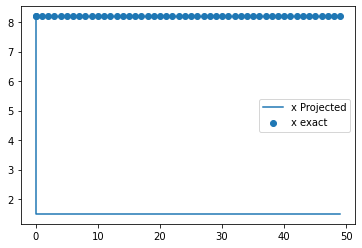

In [22]:
## Ahora con los estados gaussianos. Empiezo con max-ent1 

results = projected_evolution(author = True, x=.001, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(author = True, x=.001, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()

In [35]:
rho_me2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 2.50000625e-01+0.00e+00j  1.25000000e-06-1.25e-06j
   1.25000000e-11-1.25e-11j  0.00000000e+00+0.00e+00j]
 [ 0.00000000e+00+0.00e+00j  2.49999375e-01+0.00e+00j
   0.00000000e+00+0.00e+00j  0.00000000e+00+0.00e+00j]
 [ 0.00000000e+00+0.00e+00j  0.00000000e+00+0.00e+00j
   2.49999375e-01+0.00e+00j  0.00000000e+00+0.00e+00j]
 [ 0.00000000e+00+0.00e+00j -1.25000000e-11-1.25e-11j
  -1.25000000e-06-1.25e-06j  2.50000625e-01+0.00e+00j]]

In [33]:
#K = linalg.logm(rho_me2)
rhoj = (me.logM(rho_me2))
#rhoj.expm()
#rho_me2
#rhoj
print(rhoj.expm())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.44353558e-01+0.00000000e+00j  1.41822912e-01-1.41822912e-01j
   6.67055966e-07-6.67055966e-07j  0.00000000e+00-1.35747756e-06j]
 [ 1.41822912e-01+1.41822912e-01j  7.11638000e-01+0.00000000e+00j
   1.31072775e-06+0.00000000e+00j -6.67055966e-07+6.67055966e-07j]
 [ 6.67055966e-07+6.67055966e-07j  1.31072775e-06+0.00000000e+00j
   7.11638000e-01+0.00000000e+00j -1.41822912e-01+1.41822912e-01j]
 [ 0.00000000e+00+1.35747756e-06j -6.67055966e-07-6.67055966e-07j
  -1.41822912e-01-1.41822912e-01j  1.44353558e-01+0.00000000e+00j]]


In [34]:
kprima = linalg.logm(rho_me2)
kprima = linalg.expm(kprima)


array([[ 2.50000625e-01+0.00e+00j,  1.25000000e-06-1.25e-06j,
         1.25000000e-11-1.25e-11j,  0.00000000e+00+0.00e+00j],
       [ 0.00000000e+00+0.00e+00j,  2.49999375e-01+0.00e+00j,
         0.00000000e+00+0.00e+00j,  0.00000000e+00+0.00e+00j],
       [ 0.00000000e+00+0.00e+00j,  0.00000000e+00+0.00e+00j,
         2.49999375e-01+0.00e+00j,  0.00000000e+00+0.00e+00j],
       [ 0.00000000e+00+0.00e+00j, -1.25000000e-11-1.25e-11j,
        -1.25000000e-06-1.25e-06j,  2.50000625e-01+0.00e+00j]])

sampling: 30


/home/tomas/.conda/envs/qutip/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


sampling: 30


/home/tomas/.conda/envs/qutip/lib/python3.10/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


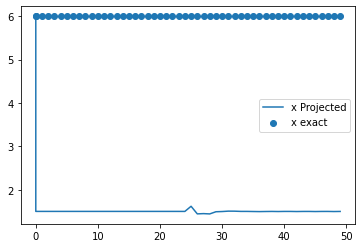

In [36]:
## Ahora testeemos un estado 2-max-ent

results = projected_evolution(author = True, x=.001, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(author = True, x=.001, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
#print(results)
plt.legend()

sampling: 15


/home/tomas/.conda/envs/qutip/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


sampling: 15


/home/tomas/.conda/envs/qutip/lib/python3.10/site-packages/matplotlib/collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


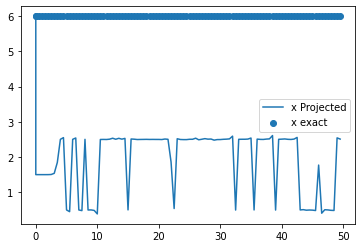

In [92]:
## usando n_body_basis(2) y el estado no gaussiano de Mauricio

results = projected_evolution(author = True, x=None, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=.5, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(author = True, x=None, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=.5, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
#print(results)
plt.legend()

sampling: 30
sampling: 30
sampling: 30
sampling: 30


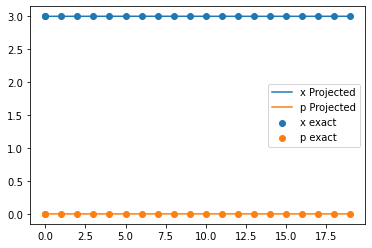

In [60]:
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,0], label="x Projected")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,1], label="p Projected")

results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="p exact")

plt.legend()

sampling: 30
sampling: 30


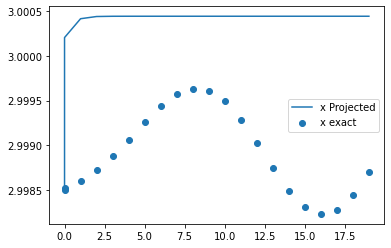

In [21]:
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()

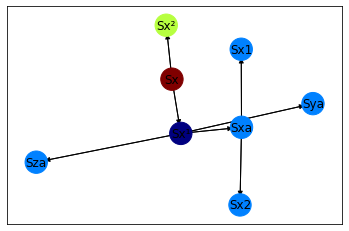

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from(
    [('Sx', 'Sx¹'), ('Sx', 'Sx²'), ('Sx¹', 'Sxa'), ('Sx¹', 'Sya'), ('Sx¹', 'Sza'), ('Sxa', 'Sx1'), ('Sxa', 'Sx2') ])

val_map = {'Sx': 1.0,
           'Sx²': 0.5714285714285714,
           'Sx¹': 0.0}

values = [val_map.get(node, 0.25) for node in G.nodes()]

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = values, node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True)
nx.draw_networkx_edges(G, pos, arrows=False)
plt.show()
